# <center>DOC2VEC</center> 



## <font color = blue>  I. DATA PREPARATION</font>

>A. LIBRARIES</br>
>B. CONSTANTS</br>
>C. COLLECTING DATA AND CREATING DICTIONARIES</br>
>D. DATA CLEANING AND DROP NaN</br>


## <font color = blue>  II.MODEL DOC2VEC</font>

>A. CREATION OF MODEL DOC2VEC</br>
>B. VOCABULARY CONSTRUCTION AND TRAINING MODEL</br>
>C. VECTORIZATION AND DROP NaN</br>
>D. SPLIT BETWEEN TRAINING SET AND TEST SET</br>


## <font color = blue>  III. MODEL DENSE</font> 

>A. CREATION OF MODEL</br>
>B. COMPILING AND TRAINING</br>
>C. TRAINING HISTORY</br>
>D. CONFUSION MATRIX</br>
>E. CLASSIFICATION REPORT</br>

## <font color = blue>  I. DATA PREPARATION</font>

>A. LIBRARIES</br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.regexp import  RegexpTokenizer
import gensim
from gensim.models import Doc2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout,Activation
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from sklearn.metrics import classification_report

> B. COLLECTING DATA</br>

In [2]:

df=pd.read_csv('data_with_text.csv')

df.head()

,Unnamed: 0.1,Unnamed: 0,filename,url,description,type,filepath,scraped,old_filename,old_filepath,height,width,channels,landscape,text
0,0,0,img_0000000.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000000.jpg,1,img_0000000.jpg,./facture/img_0000000.jpg,1061.0,750.0,3.0,0.0,FACTURE LOGO Joanna Binet 48 Coubertin 31400 ...
1,1,1,img_0000001.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000001.jpg,1,img_0000001.jpg,./facture/img_0000001.jpg,1061.0,750.0,3.0,0.0,Joanna Binet 48 Coubertin 31400 Paris FACTURE...
2,2,2,img_0000002.jpg,https://www.coover.fr/wp-content/uploads/2021/...,Facture proforma : modèle à télécharger gratui...,facture,./final/img_0000002.jpg,1,img_0000002.jpg,./facture/img_0000002.jpg,1024.0,726.0,3.0,0.0,FACTURE Mon entreprise : Nom de la société Ad...
3,3,3,img_0000003.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000003.jpg,1,img_0000003.jpg,./facture/img_0000003.jpg,1061.0,750.0,3.0,0.0,Joanna Binet 48 Coubertin 31400 Paris FACTURE...
4,4,4,img_0000004.jpg,https://files.intum.com/v/vosfactures/files/31...,Base de Connaissances - Vos Factures - Créer u...,facture,./final/img_0000004.jpg,1,img_0000004.jpg,./facture/img_0000004.jpg,771.0,773.0,3.0,1.0,Payer en ligne > FACTURE No SFIDELI F/05.2020...


In order to improve the performance, we will group some classes 

In [3]:
# Replace current classes by new classes i.e by grouping certain classes together

new_classes =  { 'advertisement': 'other_types',
                'form'        : 'other_types',
               'handwritten' : 'other_types',
               'letter' : 'other_types',
                'memo': 'other_types',
                'presentation': 'other_types',
               'invoice' :'facture',
               'news_article': 'scientific_doc',
               'scientific_publication': 'scientific_doc',
               'scientific_report': 'scientific_doc'}

df = df.replace(new_classes)

In [4]:
# Creating dictionary
dico_type = {'facture': 0,
             'id_pieces': 1,
             'justif_domicile': 2,
             'passeport': 3,
             'paye': 4,
             'carte postale': 5,
             'other_types': 6,
             'scientific_doc': 7,
             'resume': 8,
             'specification': 9,
             'budget': 10,
             'file_folder': 11,
             'email': 12,
             'questionnaire': 13}

# Creating revert dictionary
dico_type_inv = {v: k for k, v in dico_type.items()}

# Convert types according to the dictionary
df['type_num'] = df.type.replace(dico_type)

>C. DATA CLEANING AND DROP NaN</br>

In [5]:


stop_words = set(stopwords.words('english'))
stop_words.update(["." , ",",':'])
stop_words=list(stop_words)
stop_words.extend(stopwords.words('french'))
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(str(w).lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    # remove stopword
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df['text_image']  = df.text.apply(lambda x :preprocess_sentence(x))
df = df.dropna(subset = ['text_image']) # DROP NaN
df['text_image'].head(20)

0     facture logo joanna binet coubertin paris fact...
1     joanna binet coubertin paris facture facture c...
2     facture entreprise nom societe adresse postale...
3     joanna binet coubertin paris facture cendrillo...
4     payer ligne facture sfideli date creation date...
5     joanna binet coubertin paris facture cendrillo...
6     nom entreprise facture adresse ville province ...
7     ivotre societe choisir dato facture facturer c...
8     identification vendeur nom independant adresse...
9     facture joanna binet coubertin paris facture c...
10    facture date facauraton puiputt etheance renov...
11    facture nom societe adresse ville siret tel no...
12    invoice brand name invoice dwyane clark dummy ...
13    nom compagnie details contact logo adresse pos...
14    nom entreprise siogan entreprise adresse ville...
15    logo date numero facture nom entreprise adress...
16    facture nom entreprise nom entreprise com rue ...
17    contrat electricite tarif bleu kva option 

## <font color = blue>  II.MODEL DOC2VEC</font>

>A. CREATION OF MODEL DOC2VEC</br>

In [6]:

max_epochs = 100 
vec_size = 200 
alpha = 0.025 

model = Doc2Vec(vector_size=vec_size,    # Dimensionality of the feature vectors
                alpha=alpha,             # The initial learning rate                      
                min_alpha=0.00025,       # Learning rate will linearly drop to min_alpha as training progresses
                min_count=1,             # Ignores all words with total frequency lower than this
                epochs = max_epochs,     # Number of iterations    
                dm =1                    # Defines the training algorithm 
                       ) 

> B. VOCABULARY CONSTRUCTION AND TRAINING MODEL</br>



In [7]:
docs=[]
for i, text in enumerate(df.text_image):
    words = text.split()
    tags = [i]
    docs.append(gensim.models.doc2vec.TaggedDocument(words,tags))

In [8]:


model.build_vocab(docs)
model.train(docs,total_examples=model.corpus_count, epochs=100)

>C. VECTORIZATION AND DROP NaN</br>


In [9]:

data_all_num=[]

for text in df.text_image:
    data_all_num.append(model.infer_vector( text.split()))

data_all_num=pd.DataFrame(np.array(data_all_num))
data_all_num['type']=df.type 

DROP NaN

In [10]:
data_all_num=data_all_num.dropna()
data_all_num.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,type
0,-0.208936,-0.516525,0.578759,-0.343459,0.242685,0.016433,-0.345919,0.908497,-0.253137,0.038202,...,-0.162440,-0.277179,-0.068204,0.353343,0.167007,0.067515,0.295283,-0.374190,-0.054802,facture
1,-0.181088,-0.567310,0.496513,-0.053522,0.394944,0.268916,-0.404135,0.869158,-0.223896,0.285550,...,-0.103801,-0.174815,-0.132013,0.356381,0.418693,0.158995,0.362107,-0.207687,-0.057535,facture
2,0.095434,-0.232644,0.298781,0.207233,0.104164,0.121504,-0.080422,0.343701,-0.191456,0.073195,...,-0.217445,0.094848,-0.160835,-0.089767,0.121366,0.150756,-0.356025,-0.093825,-0.022038,facture
3,-0.210234,-0.689679,0.538753,-0.146082,0.372622,0.182828,-0.396144,0.990851,-0.402408,-0.018414,...,-0.071773,-0.236116,0.033858,0.232149,0.386624,-0.069050,0.275660,-0.236562,-0.164527,facture
4,0.194483,0.108582,0.278630,0.141456,0.413071,-0.181059,-0.093203,0.568709,-0.365296,-0.195688,...,-0.233529,-0.627033,-0.232621,0.225684,0.272006,0.167612,0.058915,-0.034016,0.226228,facture


>D. SPLIT BETWEEN TRAINING SET AND TEST SET</br>


In [11]:
data=data_all_num.drop(['type'],axis=1)
target=data_all_num.type.replace(list(data_all_num.type.unique()),[i for i in range(len(data_all_num.type.unique()))])

X_train,X_test, y_train, y_test=train_test_split(data,target,test_size=0.2,random_state=1234)

## <font color = blue>  III. MODEL DENSE</font> 

>A. CREATION OF MODEL</br>


In [12]:

model = Sequential()
model.add(Dense(units = 256,input_shape=(200,)))
model.add((Activation('relu')))
model.add(Dropout(0.3))
model.add(Dense(units = 14, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               51456     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                                 
Total params: 55,054
Trainable params: 55,054
Non-trainable params: 0
_________________________________________________________________


> B. COMPILING AND TRAINING</br>


In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "adam", 
              metrics = ["accuracy"])

history=model.fit(X_train,y_train,
             epochs = 500,
             batch_size = 32,
             validation_split = 0.2)

Epoch 1/500
27/27 [==============================] - 1s 12ms/step - loss: 2.3830 - accuracy: 0.2536 - val_loss: 1.9204 - val_accuracy: 0.4429
Epoch 2/500
27/27 [==============================] - 0s 3ms/step - loss: 1.7180 - accuracy: 0.4976 - val_loss: 1.7647 - val_accuracy: 0.4905
Epoch 3/500
27/27 [==============================] - 0s 3ms/step - loss: 1.4680 - accuracy: 0.5933 - val_loss: 1.6833 - val_accuracy: 0.5571
Epoch 4/500
27/27 [==============================] - 0s 3ms/step - loss: 1.3223 - accuracy: 0.6196 - val_loss: 1.6600 - val_accuracy: 0.5476
Epoch 5/500
27/27 [==============================] - 0s 3ms/step - loss: 1.2224 - accuracy: 0.6447 - val_loss: 1.5866 - val_accuracy: 0.5524
Epoch 6/500
27/27 [==============================] - 0s 3ms/step - loss: 1.1292 - accuracy: 0.6758 - val_loss: 1.5176 - val_accuracy: 0.5667
Epoch 7/500
27/27 [==============================] - 0s 3ms/step - loss: 1.0608 - accuracy: 0.6998 - val_loss: 1.4730 - val_accuracy: 0.5857
Epoch 8/500


Epoch 59/500
27/27 [==============================] - 0s 3ms/step - loss: 0.4374 - accuracy: 0.8636 - val_loss: 2.0491 - val_accuracy: 0.5905
Epoch 60/500
27/27 [==============================] - 0s 3ms/step - loss: 0.4234 - accuracy: 0.8720 - val_loss: 2.0335 - val_accuracy: 0.5810
Epoch 61/500
27/27 [==============================] - 0s 3ms/step - loss: 0.4434 - accuracy: 0.8612 - val_loss: 2.1241 - val_accuracy: 0.5810
Epoch 62/500
27/27 [==============================] - 0s 3ms/step - loss: 0.4634 - accuracy: 0.8529 - val_loss: 2.0743 - val_accuracy: 0.5905
Epoch 63/500
27/27 [==============================] - 0s 3ms/step - loss: 0.4357 - accuracy: 0.8600 - val_loss: 2.0226 - val_accuracy: 0.5905
Epoch 64/500
27/27 [==============================] - 0s 3ms/step - loss: 0.4220 - accuracy: 0.8744 - val_loss: 2.0884 - val_accuracy: 0.5857
Epoch 65/500
27/27 [==============================] - 0s 3ms/step - loss: 0.4279 - accuracy: 0.8684 - val_loss: 2.0937 - val_accuracy: 0.5762
Epoch 

27/27 [==============================] - 0s 3ms/step - loss: 0.3402 - accuracy: 0.8792 - val_loss: 2.6672 - val_accuracy: 0.5619
Epoch 117/500
27/27 [==============================] - 0s 3ms/step - loss: 0.3308 - accuracy: 0.8888 - val_loss: 2.5322 - val_accuracy: 0.5762
Epoch 118/500
27/27 [==============================] - 0s 4ms/step - loss: 0.3304 - accuracy: 0.8935 - val_loss: 2.5873 - val_accuracy: 0.5619
Epoch 119/500
27/27 [==============================] - 0s 3ms/step - loss: 0.3227 - accuracy: 0.8864 - val_loss: 2.5742 - val_accuracy: 0.5571
Epoch 120/500
27/27 [==============================] - 0s 3ms/step - loss: 0.3287 - accuracy: 0.8911 - val_loss: 2.6689 - val_accuracy: 0.5476
Epoch 121/500
27/27 [==============================] - 0s 3ms/step - loss: 0.3232 - accuracy: 0.8923 - val_loss: 2.7569 - val_accuracy: 0.5571
Epoch 122/500
27/27 [==============================] - 0s 3ms/step - loss: 0.3534 - accuracy: 0.8923 - val_loss: 2.7319 - val_accuracy: 0.5619
Epoch 123/500

27/27 [==============================] - 0s 3ms/step - loss: 0.2822 - accuracy: 0.9079 - val_loss: 3.0321 - val_accuracy: 0.5714
Epoch 174/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2885 - accuracy: 0.9055 - val_loss: 3.0325 - val_accuracy: 0.5619
Epoch 175/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2902 - accuracy: 0.8995 - val_loss: 3.0598 - val_accuracy: 0.5810
Epoch 176/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2831 - accuracy: 0.9091 - val_loss: 3.0471 - val_accuracy: 0.5667
Epoch 177/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2878 - accuracy: 0.9031 - val_loss: 3.0690 - val_accuracy: 0.5714
Epoch 178/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2871 - accuracy: 0.9103 - val_loss: 3.0736 - val_accuracy: 0.5667
Epoch 179/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2846 - accuracy: 0.9031 - val_loss: 3.0976 - val_accuracy: 0.5619
Epoch 180/500

27/27 [==============================] - 0s 3ms/step - loss: 0.2588 - accuracy: 0.9115 - val_loss: 3.6559 - val_accuracy: 0.5667
Epoch 231/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2554 - accuracy: 0.9163 - val_loss: 3.6493 - val_accuracy: 0.5571
Epoch 232/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2804 - accuracy: 0.9031 - val_loss: 3.6877 - val_accuracy: 0.5476
Epoch 233/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2655 - accuracy: 0.9067 - val_loss: 3.8272 - val_accuracy: 0.5571
Epoch 234/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2923 - accuracy: 0.8995 - val_loss: 3.4673 - val_accuracy: 0.5571
Epoch 235/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2745 - accuracy: 0.9127 - val_loss: 3.3309 - val_accuracy: 0.5667
Epoch 236/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2659 - accuracy: 0.8971 - val_loss: 3.4221 - val_accuracy: 0.5857
Epoch 237/500

27/27 [==============================] - 0s 3ms/step - loss: 0.2336 - accuracy: 0.9079 - val_loss: 4.2218 - val_accuracy: 0.5476
Epoch 288/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2544 - accuracy: 0.9163 - val_loss: 4.4063 - val_accuracy: 0.5619
Epoch 289/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.9175 - val_loss: 4.4125 - val_accuracy: 0.5381
Epoch 290/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2321 - accuracy: 0.9187 - val_loss: 4.3844 - val_accuracy: 0.5429
Epoch 291/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2304 - accuracy: 0.9187 - val_loss: 4.4414 - val_accuracy: 0.5476
Epoch 292/500
27/27 [==============================] - 0s 4ms/step - loss: 0.2413 - accuracy: 0.9127 - val_loss: 4.1263 - val_accuracy: 0.5429
Epoch 293/500
27/27 [==============================] - 0s 4ms/step - loss: 0.2374 - accuracy: 0.9079 - val_loss: 4.1711 - val_accuracy: 0.5571
Epoch 294/500

27/27 [==============================] - 0s 3ms/step - loss: 0.2243 - accuracy: 0.9187 - val_loss: 4.8180 - val_accuracy: 0.5476
Epoch 345/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2109 - accuracy: 0.9294 - val_loss: 4.8935 - val_accuracy: 0.5524
Epoch 346/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2242 - accuracy: 0.9163 - val_loss: 4.7517 - val_accuracy: 0.5476
Epoch 347/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2291 - accuracy: 0.9199 - val_loss: 4.6791 - val_accuracy: 0.5381
Epoch 348/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2333 - accuracy: 0.9246 - val_loss: 4.5411 - val_accuracy: 0.5476
Epoch 349/500
27/27 [==============================] - 0s 4ms/step - loss: 0.2270 - accuracy: 0.9270 - val_loss: 4.7502 - val_accuracy: 0.5524
Epoch 350/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.9079 - val_loss: 4.8055 - val_accuracy: 0.5524
Epoch 351/500

27/27 [==============================] - 0s 3ms/step - loss: 0.2647 - accuracy: 0.9282 - val_loss: 5.1337 - val_accuracy: 0.5667
Epoch 402/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2168 - accuracy: 0.9246 - val_loss: 5.1171 - val_accuracy: 0.5571
Epoch 403/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2142 - accuracy: 0.9199 - val_loss: 5.1594 - val_accuracy: 0.5571
Epoch 404/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2227 - accuracy: 0.9187 - val_loss: 5.1521 - val_accuracy: 0.5571
Epoch 405/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2226 - accuracy: 0.9258 - val_loss: 5.5285 - val_accuracy: 0.5333
Epoch 406/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2100 - accuracy: 0.9270 - val_loss: 5.5895 - val_accuracy: 0.5524
Epoch 407/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2008 - accuracy: 0.9258 - val_loss: 5.5670 - val_accuracy: 0.5476
Epoch 408/500

27/27 [==============================] - 0s 3ms/step - loss: 0.1954 - accuracy: 0.9402 - val_loss: 5.6016 - val_accuracy: 0.5762
Epoch 459/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9246 - val_loss: 5.6217 - val_accuracy: 0.5762
Epoch 460/500
27/27 [==============================] - 0s 3ms/step - loss: 0.1927 - accuracy: 0.9282 - val_loss: 5.6846 - val_accuracy: 0.5714
Epoch 461/500
27/27 [==============================] - 0s 3ms/step - loss: 0.1908 - accuracy: 0.9402 - val_loss: 5.6515 - val_accuracy: 0.5810
Epoch 462/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2043 - accuracy: 0.9402 - val_loss: 5.7004 - val_accuracy: 0.5714
Epoch 463/500
27/27 [==============================] - 0s 3ms/step - loss: 0.1818 - accuracy: 0.9378 - val_loss: 5.7483 - val_accuracy: 0.5762
Epoch 464/500
27/27 [==============================] - 0s 3ms/step - loss: 0.2016 - accuracy: 0.9378 - val_loss: 5.8371 - val_accuracy: 0.5762
Epoch 465/500

> C. TRAINING HISTORY</br>


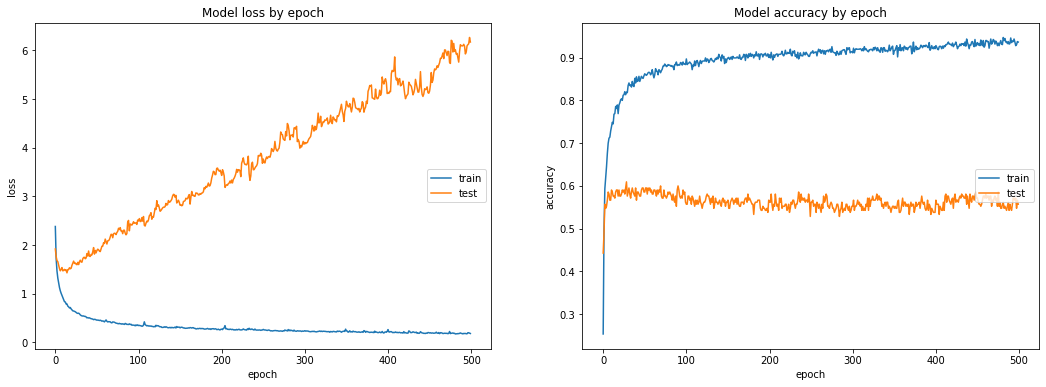

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> D. CONFUSION MATRIX</br>


In [15]:
y_prob = model.predict(X_test)

# Class predictions
y_pred = y_prob.argmax(axis=1)

9/9 [==============================] - 0s 2ms/step


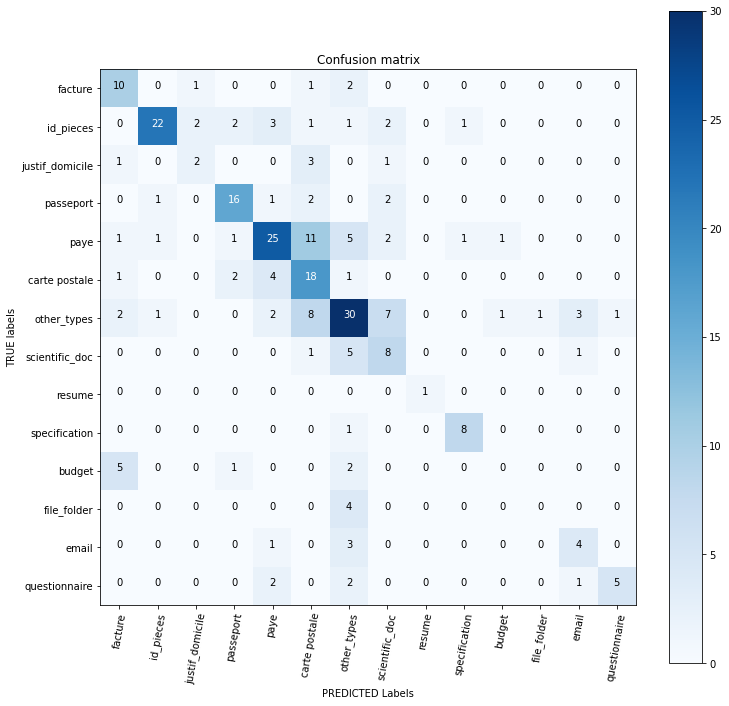

In [16]:
cnf_matrix = confusion_matrix(y_test, y_pred)

classes = dico_type
plt.figure(figsize = (12, 12))

plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 80)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('TRUE labels')
plt.xlabel('PREDICTED Labels')
plt.show()

>E. CLASSIFICATION REPORT</br>

In [17]:
target = df['type'].unique().tolist()
target_test = [target[i] for i in y_test]
target_pred = [target[i] for i in y_pred]

print( classification_report(target_test, target_pred) )

                 precision    recall  f1-score   support

         budget       0.00      0.00      0.00         8
  carte postale       0.40      0.69      0.51        26
          email       0.44      0.50      0.47         8
        facture       0.50      0.71      0.59        14
    file_folder       0.00      0.00      0.00         4
      id_pieces       0.88      0.65      0.75        34
justif_domicile       0.40      0.29      0.33         7
    other_types       0.54      0.54      0.54        56
      passeport       0.73      0.73      0.73        22
           paye       0.66      0.52      0.58        48
  questionnaire       0.83      0.50      0.62        10
         resume       1.00      1.00      1.00         1
 scientific_doc       0.36      0.53      0.43        15
  specification       0.80      0.89      0.84         9

       accuracy                           0.57       262
      macro avg       0.54      0.54      0.53       262
   weighted avg       0.58   